In [53]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import open3d as o3d
from PIL import Image

In [22]:
# use mmint_camera_utils.point_cloud_utils.load_pointcloud instead!

def load_pointcloud(pc_path, as_array=False):
    """
    Load a pointcloud as a (N,6) array
    Args:
        pc_path: path to the file containint the pointcloud
    Returns: <np.ndarray> of size (N,6)
    """
    pcd = o3d.io.read_point_cloud(pc_path)
    pc_out = pcd
    if as_array:
        pc_out = unpack_o3d_pcd(pcd)
    return pc_out
def unpack_o3d_pcd(pcd):
    """
    Convert a open3d PointCloud into a numpy array of size (N, 6)
    Args:
        pcd: open3d PointCloud object
    Returns: <np.ndarray> of size (N, 6)
    """
    pc_xyz = np.asarray(pcd.points)
    pc_rgb = np.asarray(pcd.colors)
    pc_array = np.concatenate([pc_xyz, pc_rgb], axis=-1)
    return pc_array

# Load Data

In [135]:
data_dir = '/Users/mik/Desktop/drawing_data'

In [9]:
data_dir_name = data_dir.split('/')[-1]
dl_path = os.path.join(data_dir, '{}_DataLegend.csv'.format(data_dir_name))

data_legend = pd.read_csv(dl_path)
print(len(data_legend))

29


In [8]:
data_legend[:10]

,Scene,UndeformedFC,InitialStateFC,FinalStateFC,GraspForce,start_point,end_point,direction,length,grasp_width
0,drawing_data_test,1,2,3,0,[ 0.4593247 -0.06137821],[ 0.47123356 -0.08100345],5.257803,0.022956,20
1,drawing_data_test,1,4,5,0,[0.62744389 0.08671654],[0.64642824 0.02278899],5.001061,0.066687,20
2,drawing_data_test,1,6,7,0,[ 0.51230084 -0.0546706 ],[ 0.43880377 -0.0014764 ],2.515098,0.090727,20
3,drawing_data_test,1,8,9,0,[0.58610657 0.05938848],[0.4445973 0.03203563],3.332532,0.144129,20
4,drawing_data_test,1,10,11,0,[ 0.62045048 -0.05384208],[0.57791362 0.03003817],2.040119,0.094049,20
5,drawing_data_test,1,12,13,0,[ 0.47495617 -0.07082892],[0.49390199 0.0573451 ],1.424046,0.129567,20
6,drawing_data_test,1,14,15,0,[ 0.61269282 -0.09395373],[ 0.60932543 -0.19445037],4.678894,0.100553,20
7,drawing_data_test,1,16,17,0,[ 0.45243197 -0.01433311],[0.44010931 0.02084515],1.907731,0.037274,20
8,drawing_data_test,1,18,19,0,[ 0.59012182 -0.02945543],[ 0.59012182 -0.15966636],4.712389,0.130211,20
9,drawing_data_test,1,20,21,0,[0.58405228 0.07768247],[ 0.56427345 -0.00340606],4.473144,0.083466,20


In [10]:
def load_wrench(fc, scene_name):
    wrench_dir = os.path.join(data_dir, scene_name, 'wrenches')
    wrench_file_path = os.path.join(wrench_dir, '{}_wrench_{:06}.csv'.format(scene_name, fc))
    wrench_df = pd.read_csv(wrench_file_path)
    return wrench_df

def load_tfs(fc, scene_name):
    tfs_dir = os.path.join(data_dir, scene_name, 'tfs')
    tfs_file_path = os.path.join(tfs_dir, 'recorded_tfs_{:06}.csv'.format(fc))
    tfs_df = pd.read_csv(tfs_file_path)
    return tfs_df

In [161]:
tfs_0 = load_tfs(1, 'drawing_data_test')
wrench_columns = ['wrench.force.x', 'wrench.force.y', 'wrench.force.z', 'wrench.torque.x', 'wrench.torque.y', 'wrench.torque.z']
        
tfs_0

,Unnamed: 0,parent_frame,child_frame,x,y,z,qx,qy,qz,qw
0,0,med_base,pico_flexx_left_link,0.616194,-0.291779,0.403247,0.133626,-0.282017,0.840817,0.442310
1,1,med_base,pico_flexx_right_link,0.384525,-0.288415,0.398559,-0.844262,-0.435711,-0.154568,0.271083
2,2,med_base,pico_flexx_left_optical_frame,0.616194,-0.291779,0.403247,-0.218272,-0.793963,0.395131,0.407248
3,3,med_base,pico_flexx_right_optical_frame,0.384525,-0.288415,0.398559,-0.788668,-0.198798,-0.417390,-0.405299
4,4,med_base,grasp_frame,0.500375,-0.333685,0.368834,-0.011044,-0.892293,0.451285,-0.005751
5,5,med_base,med_kuka_link_ee,0.500315,-0.169367,0.489728,-0.638757,-0.623136,0.315040,-0.323174


In [152]:
wrench_0[wrench_0['header.frame_id'] == 'grasp_frame'][wrench_columns].values

array([[-0.76372926,  1.38097117,  1.19108045, -1.04329108,  0.80406322,
        -0.93468721]])

In [145]:
wrench_frames = wrench_0['header.frame_id']
print(wrench_frames.values)
print('grasp_frame' in wrench_frames.values)

['med_kuka_link_ee' 'grasp_frame' 'med_base']
True


In [66]:
def load_pc(fc, scene_name, camera_name):
    pc_dir = os.path.join(data_dir, scene_name, 'pico_flexx_{}'.format(camera_name), 'point_cloud_data')
    fc_file_path = os.path.join(pc_dir, '{}_pc_{:06}.ply'.format(scene_name, fc))
    # load the .ply as a point cloud
    pc_array = load_pointcloud(fc_file_path, as_array=True)
    return pc_array

def _load_img(file_dir, file_name, extension=None):
    # Load an image as a np.ndarray. The image can be saved as .png or .npy
    if extension is None:
        # find what is the file extension
        all_files_in_file_dir = [f for f in os.listdir(file_dir) if os.path.isfile(os.path.join(file_dir, f))]
        our_files_in_file_dir = [f for f in all_files_in_file_dir if file_name in f]
        our_file = our_files_in_file_dir[0]
        
    else:
        our_file = '{}.{}'.format(file_name, extension)
    path_to_file = os.path.join(file_dir, our_file)
    # read files on dir
    if '.png' in our_file:
        img = Image.open(path_to_file) # TODO: Test this
        img_array = np.array(img)
    elif '.npy' in our_file:
        img_array = np.load(path_to_file)
    else:
        img_array = None
    return img_array
    

def load_depth_img(fc, scene_name, camera_name):
    # depth can be saved as .png or .npy
    depth_dir = os.path.join(data_dir, scene_name, 'pico_flexx_{}'.format(camera_name), 'depth_data')
    file_name = '{}_depth_{:06}'.format(scene_name, fc)
    depth_array = _load_img(depth_dir, file_name)
    return depth_array
    
def load_color_img(fc, scene_name, camera_name):
    color_dir = os.path.join(data_dir, scene_name, 'pico_flexx_{}'.format(camera_name), 'color_data')
    file_name = '{}_color_{:06}'.format(scene_name, fc)
    color_array = _load_img(color_dir, file_name, extension='png')
    return color_array
    

In [67]:
depth_img_i = load_depth_img(1, 'drawing_data_test', 'right')

In [68]:
depth_img_i.shape

(171, 224, 1)

In [69]:
color_img_i = load_color_img(1, 'drawing_data_test', 'right')
color_img_i.shape

(171, 224)

In [70]:
import matplotlib.pyplot as plt

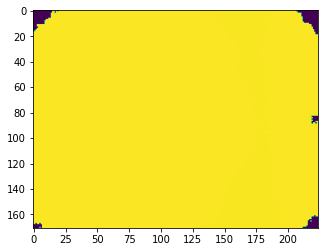

In [72]:
plt.imshow(depth_img_i[])

In [78]:
depth_img_trimmed = depth_img_i[20:160,25:200]

In [80]:
print(np.max(depth_img_trimmed))
print(np.min(depth_img_trimmed))

1038055203
1032525239


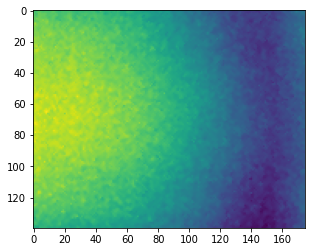

In [81]:
plt.imshow(depth_img_trimmed)

In [82]:
def process_bubble_img(bubble_img):
    # remove borders = 
    bubble_img_out = bubble_img[20:160,25:200]
    return bubble_img_out

In [124]:
def get_depth_imprint(line_indx, camera_name, initial=True):
    line_i = data_legend.iloc[line_indx]
    scene_name = line_i['Scene']
    undef_fc = line_i['UndeformedFC']
    init_fc = line_i['InitialStateFC']
    final_fc = line_i['FinalStateFC']
    undef_depth = load_depth_img(undef_fc, scene_name, camera_name)
    def_fc = final_fc
    if initial:
        def_fc = init_fc
    undef_depth = load_depth_img(undef_fc, scene_name, camera_name)/1e9 # convert it to meters
    def_depth = load_depth_img(def_fc, scene_name, camera_name)/1e9 # convert it to meters
    imprint_depth = def_depth - undef_depth
    processed_imprint = process_bubble_img(imprint_depth)
    return processed_imprint
    
    
def get_move_delta(line_indx, camera_name):
    initial_imprint = get_depth_imprint(line_indx, camera_name, initial=True)
    final_imprint = get_depth_imprint(line_indx, camera_name, initial=False)
    delta_imprint = final_imprint - initial_imprint
    return delta_imprint

### Initial States:

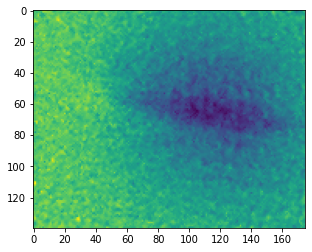

In [114]:
imprint_i = get_depth_imprint(0, 'right')
plt.imshow(imprint_i)

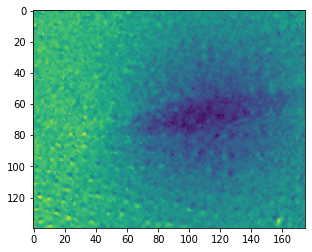

In [115]:
imprint_i = get_depth_imprint(0, 'left')
plt.imshow(np.exp(imprint_i/10**8))

(array([ 136.,  862., 1909., 3958., 6064., 5060., 5043., 1385.,   72.,
          11.]),
 array([-1.6198430e-03, -1.3567231e-03, -1.0936032e-03, -8.3048330e-04,
        -5.6736340e-04, -3.0424350e-04, -4.1123600e-05,  2.2199630e-04,
         4.8511620e-04,  7.4823610e-04,  1.0113560e-03]),
 <BarContainer object of 10 artists>)

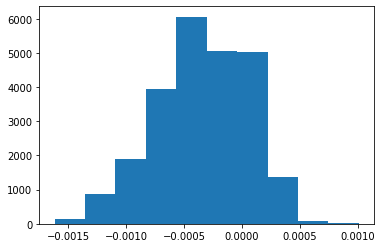

In [118]:
plt.hist(imprint_i.flatten())

### Final States

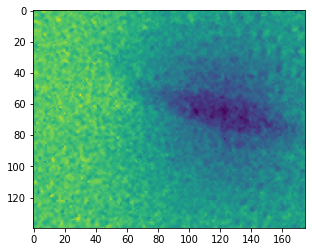

In [120]:
imprint_i = get_depth_imprint(0, 'right', initial=False)
plt.imshow(imprint_i)

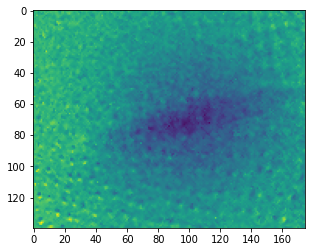

In [121]:
imprint_i = get_depth_imprint(0, 'left', initial=False)
plt.imshow(imprint_i)

(array([  31.,  423., 1301., 3242., 6103., 7861., 4897.,  578.,   54.,
          10.]),
 array([-0.00186535, -0.00157641, -0.00128746, -0.00099852, -0.00070958,
        -0.00042064, -0.0001317 ,  0.00015724,  0.00044618,  0.00073512,
         0.00102406]),
 <BarContainer object of 10 artists>)

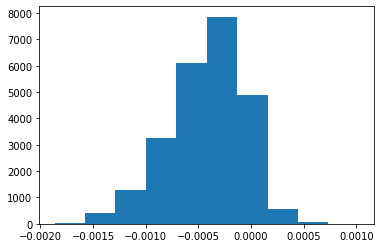

In [122]:
plt.hist(imprint_i.flatten())

### Delta Imprint Move:

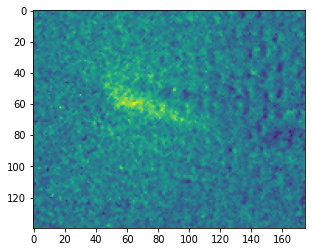

In [130]:
imprint_delta_i = get_move_delta(0, 'right')
plt.imshow(imprint_delta_i)

(array([1.3000e+01, 1.9500e+02, 1.4390e+03, 7.0000e+03, 1.0047e+04,
        4.5180e+03, 9.4900e+02, 2.6400e+02, 6.7000e+01, 8.0000e+00]),
 array([-6.172880e-04, -4.677562e-04, -3.182244e-04, -1.686926e-04,
        -1.916080e-05,  1.303710e-04,  2.799028e-04,  4.294346e-04,
         5.789664e-04,  7.284982e-04,  8.780300e-04]),
 <BarContainer object of 10 artists>)

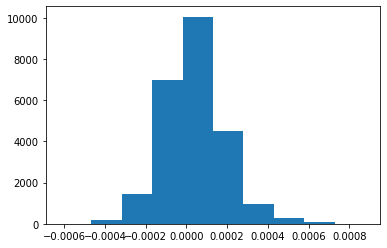

In [131]:
imprint_delta_i = get_move_delta(0, 'right')
plt.hist(imprint_delta_i.flatten())

-0.0009252580000000954

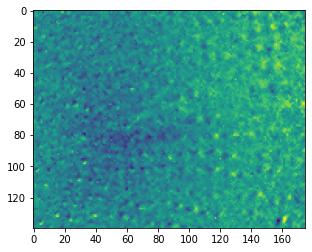

In [128]:
imprint_delta_i = get_move_delta(0, 'left')
plt.imshow(imprint_delta_i)
np.min(imprint_delta_i)

(array([  15.,  105.,  688., 3406., 7689., 7745., 3834.,  868.,  132.,
          18.]),
 array([-9.252580e-04, -7.573304e-04, -5.894028e-04, -4.214752e-04,
        -2.535476e-04, -8.562000e-05,  8.230760e-05,  2.502352e-04,
         4.181628e-04,  5.860904e-04,  7.540180e-04]),
 <BarContainer object of 10 artists>)

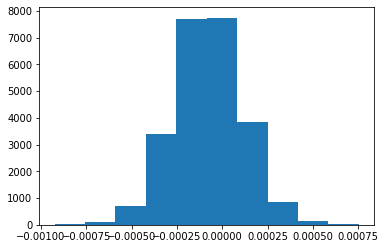

In [132]:
imprint_delta_i = get_move_delta(0, 'left')
plt.hist(imprint_delta_i.flatten())

In [153]:
imprint_delta_i.shape

(140, 175, 1)

In [154]:
data_legend

,Scene,UndeformedFC,InitialStateFC,FinalStateFC,GraspForce,start_point,end_point,direction,length,grasp_width
0,drawing_data_test,1,2,3,0,[ 0.4593247 -0.06137821],[ 0.47123356 -0.08100345],5.257803,0.022956,20
1,drawing_data_test,1,4,5,0,[0.62744389 0.08671654],[0.64642824 0.02278899],5.001061,0.066687,20
2,drawing_data_test,1,6,7,0,[ 0.51230084 -0.0546706 ],[ 0.43880377 -0.0014764 ],2.515098,0.090727,20
3,drawing_data_test,1,8,9,0,[0.58610657 0.05938848],[0.4445973 0.03203563],3.332532,0.144129,20
4,drawing_data_test,1,10,11,0,[ 0.62045048 -0.05384208],[0.57791362 0.03003817],2.040119,0.094049,20
5,drawing_data_test,1,12,13,0,[ 0.47495617 -0.07082892],[0.49390199 0.0573451 ],1.424046,0.129567,20
6,drawing_data_test,1,14,15,0,[ 0.61269282 -0.09395373],[ 0.60932543 -0.19445037],4.678894,0.100553,20
7,drawing_data_test,1,16,17,0,[ 0.45243197 -0.01433311],[0.44010931 0.02084515],1.907731,0.037274,20
8,drawing_data_test,1,18,19,0,[ 0.59012182 -0.02945543],[ 0.59012182 -0.15966636],4.712389,0.130211,20
9,drawing_data_test,1,20,21,0,[0.58405228 0.07768247],[ 0.56427345 -0.00340606],4.473144,0.083466,20
